In [ ]:
import json

import geopandas as gpd
import numpy as np
import pandas as pd


def calculate_gini(array: np.array) -> np.float64:
    """based on: https://github.com/oliviaguest/gini (CC0 1.0)"""
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return np.round((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)), 4)

In [2]:
CITY = "budapest"
VERSION = "20250428"

In [ ]:
pp = pd.read_csv("~/PhD/dissertation/data/ingatlancom/cleaned_ingatlancom.csv")
pp = gpd.GeoDataFrame(pp, geometry=gpd.points_from_xy(pp["lon"], pp["lat"]), crs=4326)
pp = pp[["geometry", "norm_price"]].copy()

In [23]:
sgfw = gpd.read_file(f"../output/{CITY}/{VERSION}/stop_geometries_from_walk.geojson")
sgfw = sgfw.sjoin(pp).drop("index_right", axis=1)

In [24]:
mean_price = sgfw.groupby(["stop_id"])["norm_price"].mean()

<Axes: >

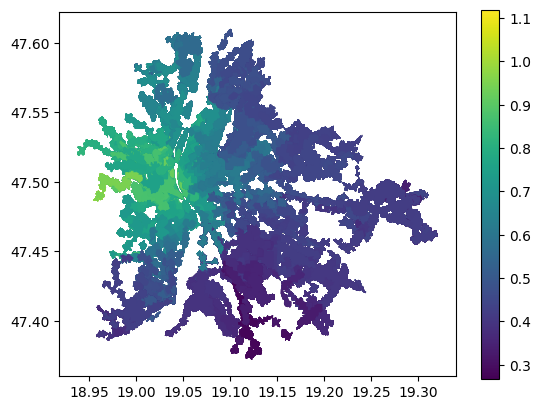

In [ ]:
sgfw.drop("norm_price", axis=1).drop_duplicates("stop_id").merge(
    mean_price, on="stop_id"
).plot(column="norm_price", legend=True)

In [6]:
with open(f"../data/stops/{CITY}/{VERSION}/accessible_stops.json", "r") as fp:
    accessible_stops = json.load(fp)

In [ ]:
result = {}
for stop, accessible in accessible_stops.items():
    result[stop] = sgfw[sgfw["stop_id"].isin(accessible)]["norm_price"].tolist()

In [ ]:
with open(f"../output/{CITY}/{VERSION}/multimodal_pp.json", "w") as fp:
    json.dump(result, fp)

In [31]:
stop_gini = {}
for k, v in result.items():
    stop_gini[k] = calculate_gini(np.array(v))

In [ ]:
with open(f"../output/{CITY}/{VERSION}/multimodal_stop_gini.json", "w") as fp:
    json.dump(stop_gini, fp)

In [22]:
with open(f"../output/{CITY}/{VERSION}/multimodal_stop_gini.json", "r") as fp:
    stop_gini = json.load(fp)

In [26]:
records = []
for k, v in stop_gini.items():
    records.append([k, v])
pd.DataFrame.from_records(records, columns=["stop_id", "multimodal_gini"]).sort_values(
    "stop_id"
).to_csv(f"../output/{CITY}/{VERSION}/multimodal_stop_gini.csv", index=False)

In [ ]:
walk_accessibility = gpd.read_file(f"../output/{CITY}/{VERSION}/isochrones.geojson")
walk_accessibility = walk_accessibility.query("costing == 'walk' & range == 15").copy()
walk_accessibility = walk_accessibility.sjoin(pp).drop("index_right", axis=1)

In [ ]:
walk15_gini = (
    walk_accessibility.groupby("stop_id")["norm_price"]
    .apply(calculate_gini)
    .reset_index()
)
walk15_gini.rename({"norm_price": "walk15_gini"}, axis=1, inplace=True)

In [ ]:
walk15_gini.sort_values("stop_id").to_csv(
    f"../output/{CITY}/{VERSION}/walk15_stop_gini.csv", index=False
)